In [174]:
import pandas as pd
import snorkel
import matplotlib.pyplot as plt
from snorkel.labeling import labeling_function
from snorkel.labeling import LFAnalysis
from snorkel.labeling.model import MajorityLabelVoter
from snorkel.labeling import PandasLFApplier
from snorkel.labeling.model import LabelModel
import seaborn as sns

In [485]:
# read in the training data
df_train = pd.read_csv("data/training_set_seattle.csv")

In [486]:
# read in the training data
df_train = pd.read_csv("data/training_set_seattle.csv")

<AxesSubplot:>

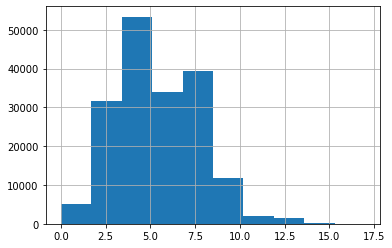

In [487]:
#plot count histogram
df_train['count'].hist()

In [488]:
#select only label_type = curb ramp
df_train = df_train[df_train['label_type'] == 'CurbRamp']
#df_train

In [518]:
# read in gt.csv file
df_test = pd.read_csv('data/test_set_seattle.csv')
#select only label_type = curb ramp
df_test = df_test[df_test['label_type'] == 'CurbRamp']
Y_test = df_test.verified.values


## Labeling functions based on heuristics

In [491]:
# Define the label mappings for convenience
NOT_SURE = -1
WRONG = 0
CORRECT = 1

### intersection

In [492]:
#check if it is in the curb false positive list
@labeling_function()
def intersection(x):
    # x in this case is a row of the dataframe
    return WRONG if x["false_positive"] == 1 else NOT_SURE

### cluster

In [493]:
#check if the label is in the cluster
@labeling_function()
def clustered(x):
    # x in this case is a row of the dataframe
    return CORRECT if x['count'] >= 5 else NOT_SURE

### severity

In [494]:
#check if it is a severity 4 or higher
@labeling_function()
def severity(x):
    # x in this case is a row of the dataframe
    return CORRECT if x["severity"] >= 4 else NOT_SURE

### gsv

In [495]:
#check if the user zoomed in
@labeling_function()
def zoom(x):
    # x in this case is a row of the dataframe
    if x["zoom"] > 2:
        return CORRECT
    elif x["zoom"] == 1:
        return WRONG
    else:
        return NOT_SURE

### optional input

In [496]:
#check if the user has put a tag
@labeling_function()
def tags(x):
    # x in this case is a row of the dataframe
    return CORRECT if x['label_tags']  == 1 else NOT_SURE

In [497]:
#check if the user has put a comment
@labeling_function()
def description(x):
    # x in this case is a row of the dataframe
    return CORRECT if x['label_description']  == 1 else NOT_SURE

In [498]:
#check for distance to the curb
@labeling_function()
def distance(x):
    # x in this case is a row of the dataframe
    return WRONG if x['distance']  >= 10 else NOT_SURE

In [499]:
lfs = [
    intersection, 
    zoom, 
    tags, 
    description,
    severity,
    clustered,
    distance
    ]

In [500]:
applier = PandasLFApplier(lfs=lfs)

In [501]:
L_train = applier.apply(df=df_train)
L_test = applier.apply(df=df_test)

100%|██████████| 5333/5333 [00:00<00:00, 39404.75it/s]


In [502]:
LFAnalysis(L=L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
intersection,0,[0],0.095247,0.090819,0.046188
zoom,1,"[0, 1]",0.765950,0.548154,0.369967
tags,2,[1],0.001019,0.001019,0.000806
description,3,[1],0.000085,0.000085,0.000071
severity,4,[1],0.018687,0.017838,0.014500
clustered,5,[1],0.535847,0.453855,0.382246
distance,6,[0],0.314076,0.286957,0.196902


In [503]:
majority_model = MajorityLabelVoter()
preds_train = majority_model.predict(L=L_train)

In [504]:
label_model = LabelModel(cardinality=2, verbose=True)
label_model.fit(L_train=L_train, n_epochs=500, log_freq=100, seed=123)

INFO:root:Computing O...
INFO:root:Estimating \mu...
  0%|          | 0/500 [00:00<?, ?epoch/s]INFO:root:[0 epochs]: TRAIN:[loss=0.492]
INFO:root:[100 epochs]: TRAIN:[loss=0.000]
INFO:root:[200 epochs]: TRAIN:[loss=0.000]
INFO:root:[300 epochs]: TRAIN:[loss=0.000]
100%|██████████| 500/500 [00:00<00:00, 3254.85epoch/s]
INFO:root:Finished Training


In [505]:
majority_acc = majority_model.score(L=L_test, Y=Y_test, tie_break_policy="random")[
    "accuracy"
]
print(f"{'Majority Vote Accuracy:':<25} {majority_acc * 100:.1f}%")

label_model_acc = label_model.score(L=L_test, Y=Y_test, tie_break_policy="random")[
    "accuracy"
]
print(f"{'Label Model Accuracy:':<25} {label_model_acc * 100:.1f}%")

Majority Vote Accuracy:   51.6%
Label Model Accuracy:     42.1%
